<a href="https://colab.research.google.com/github/distributed-information-bottleneck/distributed-information-bottleneck.github.io/blob/main/complex_systems/InfoDecomp_Fig5_Mutual_information_bounds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
This code accompanies
"Information decomposition to identify relevant variation in complex systems with machine learning"
Kieran A Murphy and Dani S Bassett

The following reproduces the mutual information bound analysis (Fig. 5, in the appendices)
'''

In [3]:
#@title imports
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
from matplotlib import cm
import scipy.ndimage as nim
from matplotlib.gridspec import GridSpec
from scipy import stats

from sklearn import svm

tfkl = tf.keras.layers
default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

outdir = 'Experiments/20230423 explanatory round2/info_bounds_supp'

In [21]:
#@title Mutual information estimation, modified to take mus and logvars
def estimate_mi_sandwich_bounds(mus, logvars,
  evaluation_batch_size=1024, number_evaluation_batches=8):
  """Computes the upper and lower bounds of mutual information for a synthetic scenario

  Let the compression channel be given by a transformation from categorical X to
  normal distributions in U, whose parameters are given by mus and logvars.
  How well can we estimation the mutual information transmitted by the compression
  channel?
  As the conditional distribution is known, we can use the InfoNCE lower and
  "leave one out" upper bounds from Poole et al. (2019).

  The only change from the code used to compute mutual information bounds in the
  rest of the manuscript is we have no need for a dataset or encoder; it's
  been specified manually.

  Args:
    mus, logvars: The parameters for p(u|x), a multivariate Gaussian for each data
      point x
    evaluation_batch_size: The number of data points to use for each batch when
      estimating the upper and lower bounds.  Increasing this parameter yields
      tighter bounds on the mutual information.
    number_evaluation_batches: The number of batches over which to average the
      upper and lower bounds.  Increasing this parameter reduces the uncertainty
      of the bounds.
  Returns:
    Lower and upper bound estimates for the communication channel represented by
    the encoder.
  """
  @tf.function
  def compute_batch(mus, logvars):
    # We desire extra numerical precision below; cast to float64
    mus = tf.cast(mus, tf.float64)
    logvars = tf.cast(logvars, tf.float64)
    embedding_dimension = tf.shape(mus)[-1]
    stddevs = tf.exp(logvars/2.)
    sampled_u_values = tf.random.normal(mus.shape, mean=mus,
                                        stddev=stddevs, dtype=tf.float64)
    # Expand dimensions to broadcast and compute the pairwise distances between
    # the sampled points and the centers of the conditional distributions
    sampled_u_values = tf.reshape(sampled_u_values,
     [evaluation_batch_size, 1, embedding_dimension])
    mus = tf.reshape(mus, [1, evaluation_batch_size, embedding_dimension])
    distances_ui_muj = sampled_u_values - mus

    normalized_distances_ui_muj = distances_ui_muj / tf.reshape(stddevs, [1, evaluation_batch_size, embedding_dimension])
    p_ui_cond_xj = tf.exp(-tf.reduce_sum(normalized_distances_ui_muj**2, axis=-1)/2. - \
      tf.reshape(tf.reduce_sum(logvars, axis=-1), [1, evaluation_batch_size])/2.)
    normalization_factor = (2.*np.pi)**(tf.cast(embedding_dimension, tf.float64)/2.)
    p_ui_cond_xj = p_ui_cond_xj / normalization_factor
    # InfoNCE (lower bound) is the diagonal terms over their rows, averaged
    p_ui_cond_xi = tf.linalg.diag_part(p_ui_cond_xj)
    avg_pui_cond_xj = tf.reduce_mean(p_ui_cond_xj, axis=1)
    infonce_lower = tf.reduce_mean(tf.math.log(p_ui_cond_xi/tf.reduce_mean(p_ui_cond_xj, axis=1)))
    # "Leave one out" (upper bound) is the same but without the diagonal term in the denom
    p_ui_cond_xj *= (1. - tf.eye(evaluation_batch_size, dtype=tf.float64))
    loo_upper = tf.reduce_mean(tf.math.log(p_ui_cond_xi/tf.reduce_mean(p_ui_cond_xj, axis=1)))
    return infonce_lower, loo_upper

  # number_evaluation_batches*evaluation_batch_size can be larger than the dataset
  # We gain from re-sampling u even if we have seen the data point x before
  bound_estimates = []
  for _ in range(number_evaluation_batches):
    batch_inds = np.random.choice(mus.shape[0], evaluation_batch_size)
    batch_mus = mus[batch_inds]
    batch_logvars = logvars[batch_inds]
    bound_estimates.append(compute_batch(batch_mus, batch_logvars))

  return np.stack(bound_estimates, 0)/np.log(2)

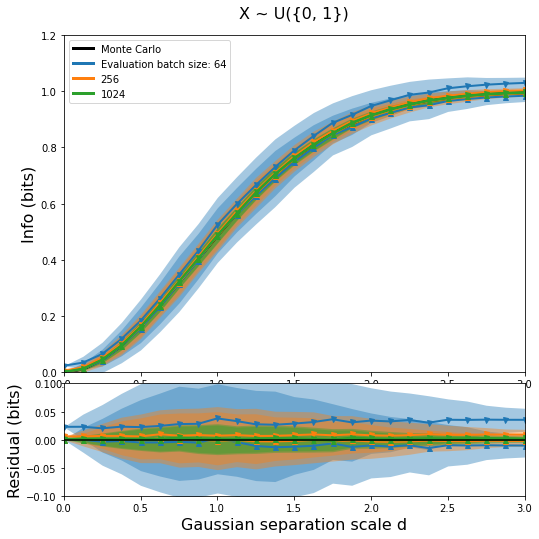

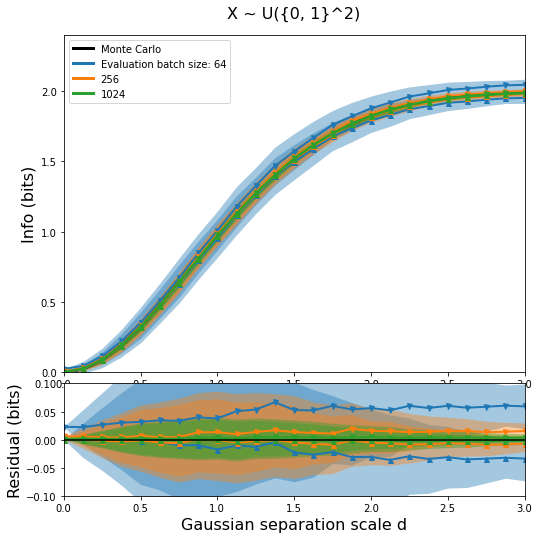

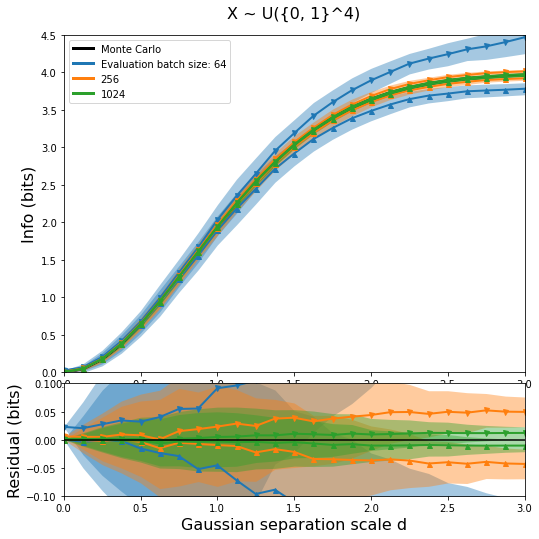

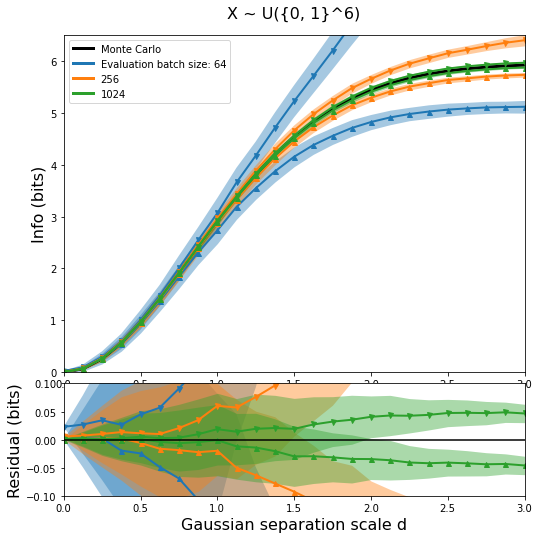

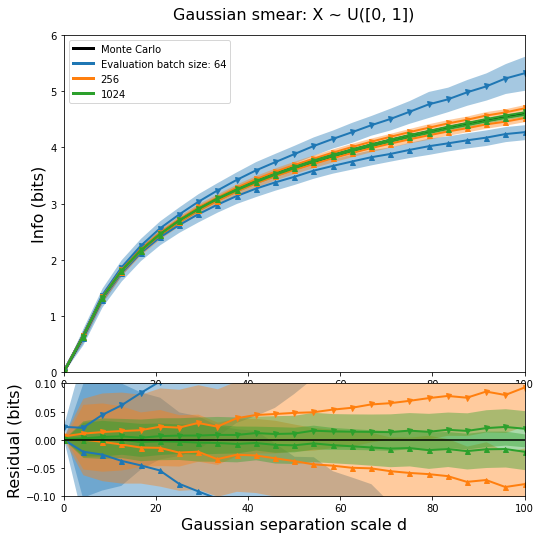

In [24]:
# This code takes a while because it averages a ton
# To shrink the run time, reduce the number of monte carlo runs and the number of evaluation batches

# Below are five different random variables X; the four from the paper and then
# a bonus one that is continuous instead of discrete
x_sample_fns = [lambda sample_size: np.random.randint(2, size=(sample_size, 1))*2-1,
                lambda sample_size: np.random.randint(2, size=(sample_size, 2))*2-1,
                lambda sample_size: np.random.randint(2, size=(sample_size, 4))*2-1,
                lambda sample_size: np.random.randint(2, size=(sample_size, 6))*2-1,
                lambda sample_size: np.random.uniform(size=(sample_size, 1))-0.5]
plot_labels = ['X ~ U({0, 1})', 'X ~ U({0, 1}^2)', 'X ~ U({0, 1}^4)', 'X ~ U({0, 1}^6)', 'Gaussian smear: X ~ U([0, 1])']
# For each, we'll parameterize the compression channel as mapping each x to a Gaussian in u, separated from other x by a changing scale factor
separation_scales_all = [*[np.linspace(0, 3, 25)]*4, np.linspace(0, 100, 25)]
# The y axis plot limits for each
info_plot_lims_all = [[0, 1.2], [0, 2.4], [0, 4.5], [0, 6.5], [0, 6]]
info_residuals_lims_all = [[-0.1, 0.1]]*len(x_sample_fns)

# The dimension of U
embedding_dimension = 32
# A fixed dataset of points is sampled from X, and used for all subsequent evaluation (including the Monte Carlo estimate)
train_size = 1024
# We'll sweep over the batch sized used in the mutual information bound calculations
evaluation_batch_sizes = [64, 256, 1024]
# This number was larger (4096) for figure-quality results, but we'll drop it down for speed here
number_evaluation_batches = 512
fill_between_alpha = 0.4

# The normal distributions p(u|x) all have the same variance of 1.  All we do is move around their centers
logvar = 0.

# For the Monte Carlo estimate, we're just sampling a ton of points in U to get
# the expected value of log p(u|x)/p(u).  We'll sample 10k points at a time, and
# then repeat for several batches
mc_sample_size = 10_000
number_monte_carlo_runs = 200

# For the info estimate curves
markersize = 5

for plot_label, x_sample_fn, separation_scales, info_plot_lims, info_residual_lims in zip(plot_labels, x_sample_fns, separation_scales_all, info_plot_lims_all, info_residuals_lims_all):
  fig = plt.figure(figsize=(8, 8))
  gs = fig.add_gridspec(2, 1, height_ratios=(3, 1),
                    left=0.1, right=0.9, bottom=0.1,
                     top=0.9,
                    wspace=0.05, hspace=0.05)
  # Generate the dataset in X
  x_samples_train = x_sample_fn(train_size)

  ############################################# Compute the Monte Carlo estimate
  monte_carlo = []
  for separation_scale in separation_scales:
    u_mus_train = np.concatenate([x_samples_train*separation_scale, np.zeros((train_size, embedding_dimension-x_samples_train.shape[-1]))], -1)
    mc_estimates = []
    for monte_carlo_trial in range(number_monte_carlo_runs):
      x_samples_mc = np.random.choice(train_size, size=mc_sample_size)
      u_samples = np.float32([np.random.normal(loc=u_mus_train[x_id], scale=np.exp(logvar/2.)) for x_id in x_samples_mc])
      stat_dists = np.linalg.norm(np.reshape(u_mus_train, [-1, 1, embedding_dimension])-np.reshape(u_samples, [1, -1, embedding_dimension]), ord=2, axis=-1)  ## [train_size, mc_size]
      normalization_factor = (2.*np.pi)**(embedding_dimension/2.)
      p_u = np.mean(np.exp(-stat_dists**2/2. - logvar/2.)/normalization_factor, axis=0)
      stat_dists_ugx = np.linalg.norm([u_mus_train[x_samples_mc[sample_ind]]-u_samples[sample_ind] for sample_ind in range(mc_sample_size)], ord=2, axis=-1)
      p_ugx = np.exp(-stat_dists_ugx**2/2. - logvar/2.)/normalization_factor
      mc_estimates.append(np.average(np.log2(p_ugx/p_u)))
    monte_carlo.append(np.average(mc_estimates))
  monte_carlo = np.float32(monte_carlo)

  ########################### Compute the info bounds with different batch sizes
  info_bound_estimates = []
  for evaluation_batch_size in evaluation_batch_sizes:

    for separation_scale in separation_scales:
      u_mus_train = np.concatenate([x_samples_train*separation_scale, np.zeros((train_size, embedding_dimension-x_samples_train.shape[-1]))], -1)
      info_bound_estimates.append(estimate_mi_sandwich_bounds(u_mus_train,
                                                        np.ones_like(u_mus_train)*logvar,
                                                        evaluation_batch_size=evaluation_batch_size,
                                                        number_evaluation_batches=number_evaluation_batches))

  # The estimates are in an array indexed by [evaluation batch size, separation scale, every batch's value, lower/upper bound]
  info_bound_estimates = np.reshape(info_bound_estimates, [len(evaluation_batch_sizes), separation_scales.shape[0], number_evaluation_batches, 2])

  info_bound_stats = np.stack([np.mean(info_bound_estimates[..., 0], axis=-1),
                                np.std(info_bound_estimates[..., 0], axis=-1),
                                np.mean(info_bound_estimates[..., 1], axis=-1),
                                np.std(info_bound_estimates[..., 1], axis=-1)], -1)

  ax = fig.add_subplot(gs[0])
  plt.plot(separation_scales, monte_carlo, 'k', lw=3, label='Monte Carlo')

  for plot_id, evaluation_batch_size in enumerate(evaluation_batch_sizes):
    lowers = info_bound_stats[plot_id, :, 0]
    lowers_err = info_bound_stats[plot_id, :, 1]
    uppers = info_bound_stats[plot_id, :, 2]
    uppers_err = info_bound_stats[plot_id, :, 3]
    plt.plot(separation_scales, lowers, '^-', color=default_colors[plot_id], markersize=markersize, lw=2)
    plt.fill_between(separation_scales, lowers-lowers_err, lowers+lowers_err, color=default_colors[plot_id], alpha=fill_between_alpha, lw=0)

    plt.plot(separation_scales, uppers, 'v-', color=default_colors[plot_id], markersize=markersize, lw=2)
    plt.fill_between(separation_scales, uppers-uppers_err, uppers+uppers_err, color=default_colors[plot_id], alpha=fill_between_alpha, lw=0)
    plt.plot(0, 0, lw=3, color=default_colors[plot_id], label=f'{["Evaluation batch size: ", ""][plot_id>0]}{evaluation_batch_size}')
  plt.ylabel('Info (bits)', fontsize=16)
  plt.ylim(info_plot_lims)
  plt.xlim(separation_scales[0], separation_scales[-1])
  plt.legend()

  ## Plot the residual from the Monte Carlo estimate
  ax = fig.add_subplot(gs[1])

  for plot_id, evaluation_batch_size in enumerate(evaluation_batch_sizes):
    lowers = info_bound_stats[plot_id, :, 0]
    lowers_err = info_bound_stats[plot_id, :, 1]
    uppers = info_bound_stats[plot_id, :, 2]
    uppers_err = info_bound_stats[plot_id, :, 3]
    plt.plot(separation_scales, lowers-monte_carlo, '^-', color=default_colors[plot_id], markersize=markersize, lw=2)
    plt.fill_between(separation_scales, lowers-lowers_err-monte_carlo, lowers+lowers_err-monte_carlo, color=default_colors[plot_id], alpha=fill_between_alpha, lw=0)

    plt.plot(separation_scales, uppers-monte_carlo, 'v-', color=default_colors[plot_id], markersize=markersize, lw=2)
    plt.fill_between(separation_scales, uppers-uppers_err-monte_carlo, uppers+uppers_err-monte_carlo, color=default_colors[plot_id], alpha=fill_between_alpha, lw=0)

  plt.ylabel('Residual (bits)', fontsize=16)
  plt.xlabel('Gaussian separation scale d', fontsize=16)
  plt.ylim(info_residual_lims)
  plt.xlim(separation_scales[0], separation_scales[-1])
  plt.axhline(0, color='k')
  plt.suptitle(plot_label, fontsize=16, y=0.95)
  plt.show()